In [48]:
!pwd

/Users/yuanshi/Library/CloudStorage/Box-Box/Sequence Analysis/2025/D1D2_organize/script_DNA


python(12758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [49]:
import pickle, json, os, hashlib
import pandas as pd
from statannotations.Annotator import Annotator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [50]:
#check md5 and store
def get_file_md5(file_path):
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as file:
        for chunk in iter(lambda: file.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def store_md5_in_json(file_paths, json_output):
    md5_dict = {}
    for file_path in file_paths:
        md5_hash = get_file_md5(file_path)
        md5_dict[file_path] = md5_hash

    with open(json_output, "w") as json_file:
        json.dump(md5_dict, json_file, indent=4)

# Check odds ratios

## Question 1: does D1D2-NK integration more likely to integrate to gene location? How about other regulatory locations?

In [51]:
# load data
perIS = pd.read_csv('../csvfiles/perIS_intersect.csv')

In [52]:
perIS.columns

Index(['site', 'SampleID', 'Mouse_Cohort', 'MouseID', 'AnimalID', 'Organ',
       'Treatment', 'UMI', 'barcode', 'Proliferation', 'Transcription_Organ',
       'Transcription_Animal', 'Transcription_TB', 'Viremia', 'Gene_Name',
       'ENSG', 'Gene_Type', 'multiple genes', 'In_Gene',
       'In_open_chromatin_region', 'In_promoter', 'In_CTCF_binding_site',
       'In_TF_binding_site', 'In_enhancer'],
      dtype='object')

In [53]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.proportion import proportion_confint

def cal_odds_ratio(df,element):
    summary = (df.groupby('Treatment', as_index=False).agg(n_total=('site','size'),n_in_element=('In_{}'.format(element),'sum')))
    summary['prop_in_element'] = summary['n_in_element'] / summary['n_total']
    # 95% CIs (Wilson)
    cis = [proportion_confint(row.n_in_element, row.n_total, method='wilson') for row in summary.itertuples(index=False)]
    summary['ci_low'], summary['ci_high'] = zip(*cis)
    summary = summary.sort_values('prop_in_element', ascending=False)
    summary = summary.rename(columns={'prop_in_element': 'pro_in_{}'.format(element),'n_in_element':'n_in_{}'.format(element)})

    return summary

def fisher_vs(df,element, group_other, alternative='greater'):
    name = 'In_{}'.format(element)
    a = df[df['Treatment']=='D1D2-NK']
    b = df[df['Treatment']==group_other]
    table = [[int(a[name].sum()), int((~a[name]).sum())],[int(b[name].sum()), int((~b[name]).sum())]]
    oratio, p = fisher_exact(table, alternative=alternative)
    return table, oratio, p


def generate_explain(df,element,verbose=True):
    name = 'In_{}'.format(element)
    # D1D2-NK vs No NK
    table_1, or_1, p_1 = fisher_vs(df,element,'No NK', alternative='greater')
    if verbose:
        print("\nD1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):")
        print(f"table={table_1}  odds_ratio={or_1:.3g}  p={p_1:.3g}")

    # D1D2-NK vs GFP-NK
    table_2, or_2, p_2 = fisher_vs(df,element,'GFP-NK', alternative='greater')
    if verbose:
        print("\nD1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):")
        print(f"table={table_2}  odds_ratio={or_2:.3g}  p={p_2:.3g}")

    # Optional: D1D2-NK vs all others combined
    other = df['Treatment']!='D1D2-NK'
    a_in, a_out = int(df.loc[~other, name].sum()), int((~df.loc[~other, name]).sum())
    b_in, b_out = int(df.loc[other, name].sum()),  int((~df.loc[other, name]).sum())
    or_all, p_all = fisher_exact([[a_in, a_out],[b_in, b_out]], alternative='greater')
    if verbose:
        print("\nD1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):")
        print(f"table={[[a_in,a_out],[b_in,b_out]]}  odds_ratio={or_all:.3g}  p={p_all:.3g}")

    result_odd =  {'Element':element}
    result_p =  {'Element':element}
    
    for comp,odd in zip(('D1D2-NK vs No NK','D1D2-NK vs GFP-NK','D1D2-NK vs all others'),(or_1,or_2,or_all)):
        result_odd[comp] = odd

    for comp,p in zip(('D1D2-NK vs No NK','D1D2-NK vs GFP-NK','D1D2-NK vs all others'),(p_1,p_2,p_all)):
        result_p[comp] = p

    return result_odd,result_p

In [54]:
with open('../picklefiles/notebook5.pkl','rb') as f:
    info = pickle.load(f)

In [55]:
regulist = info['regulist']

In [56]:
perIS = pd.read_csv('../csvfiles/perIS_intersect.csv')
cal_odds_ratio(perIS,'Gene')

,Treatment,n_total,n_in_Gene,pro_in_Gene,ci_low,ci_high
0,D1D2-NK,1517,882,0.581411,0.556410,0.606000
1,GFP-NK,3601,2006,0.557067,0.540791,0.573222
2,No NK,2157,1129,0.523412,0.502312,0.544429


In [57]:
odds = []
pvals = []

for element in ['Gene']+regulist:
    odd,p = generate_explain(perIS,element,False)
    odds.append(odd)
    pvals.append(p)

odds = pd.DataFrame(odds).set_index('Element')
pvals = pd.DataFrame(pvals).set_index('Element')

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/2243673900.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


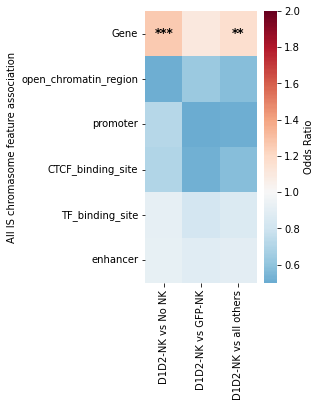

In [59]:
mask = pvals > 0.05
plt.figure(figsize=(2.5, 5))
ax = sns.heatmap(odds.astype(float),  vmin=0.5, vmax=2, cmap='RdBu_r',center=1,cbar_kws={'label':'Odds Ratio'})
for i in range(6):
    for j in range(3):
        p = pvals.iloc[i, j]
        marker = ''
        if p < 0.001:
            marker = '***'
        elif p < 0.01:
            marker = '**'
        elif p < 0.05:
            marker = '*'
                
        if marker:  # If significant, add marker
            ax.text(j + 0.5, i + 0.5, marker, 
                       horizontalalignment='center',
                       verticalalignment='center',
                       fontsize=12, weight='bold')

ax.set_ylabel('All IS chromasome feature association')
plt.tight_layout()
plt.savefig('../figures/Gene_association_all.png',dpi=300,bbox_inches="tight")

In [60]:
odds.to_csv('../csvfiles/odds_element.csv')
pvals.to_csv('../csvfiles/pval_element.csv')

In [61]:
odds = []
pvals = []

for element in ['Gene']+regulist:
    odd,p = generate_explain(perIS[perIS['Viremia']],element,False)
    odds.append(odd)
    pvals.append(p)

odds = pd.DataFrame(odds).set_index('Element')
pvals = pd.DataFrame(pvals).set_index('Element')

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/2522326958.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


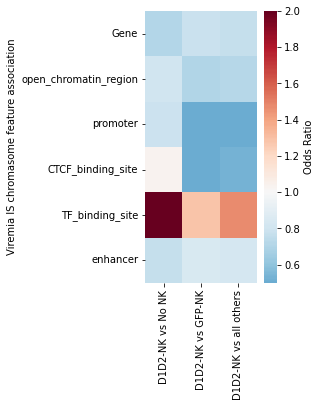

In [63]:
mask = pvals > 0.05
plt.figure(figsize=(2.5, 5))
ax = sns.heatmap(odds.astype(float),  vmin=0.5, vmax=2, cmap='RdBu_r',center=1,cbar_kws={'label':'Odds Ratio'})
for i in range(6):
    for j in range(3):
        p = pvals.iloc[i, j]
        marker = ''
        if p < 0.001:
            marker = '***'
        elif p < 0.01:
            marker = '**'
        elif p < 0.05:
            marker = '*'
                
        if marker:  # If significant, add marker
            ax.text(j + 0.5, i + 0.5, marker, 
                       horizontalalignment='center',
                       verticalalignment='center',
                       fontsize=12, weight='bold')

ax.set_ylabel('Viremia IS chromasome feature association')
plt.tight_layout()
plt.savefig('../figures/Gene_association_viremia.png',dpi=300,bbox_inches="tight")

In [64]:
odds.to_csv('../csvfiles/odds_viremia_element.csv')
pvals.to_csv('../csvfiles/pvals_viremia_element.csv')

In [65]:
for element in ['Gene']+regulist:
    print(element)
    generate_explain(perIS[perIS['Viremia']],element)

Gene

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[377, 409], [307, 235]]  odds_ratio=0.706  p=0.999

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[377, 409], [1505, 1267]]  odds_ratio=0.776  p=0.999

D1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):
table=[[377, 409], [1812, 1502]]  odds_ratio=0.764  p=1
open_chromatin_region

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[7, 779], [6, 536]]  odds_ratio=0.803  p=0.753

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[7, 779], [35, 2737]]  odds_ratio=0.703  p=0.852

D1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):
table=[[7, 779], [41, 3273]]  odds_ratio=0.717  p=0.841
promoter

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[50, 736], [43, 499]]  odds_ratio=0.788  p=0.887

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[50, 736], [472, 2300]]  odds_ratio=0.331  p=1

D1D2-NK vs others (one-sided Fi

# Distance

In [66]:
perIS = pd.read_csv('../csvfiles/perIS_distance.csv')

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/3280952714.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/3280952714.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/3280952714.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/3280952714.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.n

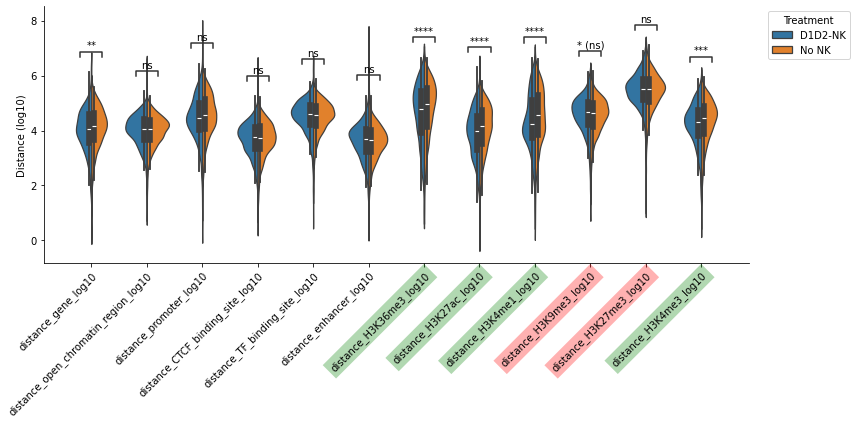

In [67]:
distance_fields = [f for f in perIS.columns if f.startswith('distance')]
Distance = perIS[['Treatment']+distance_fields].copy()
log10_col = []
for feature in distance_fields:
    log10_col.append('{}_log10'.format(feature))
    Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)

df_melted = Distance.melt(id_vars=['Treatment'], 
                    value_vars=log10_col,
                    var_name='Genetic Feature', 
                    value_name='Distance (log10)')


import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import numpy as np

# keep only the two groups you want to compare
df_filtered = df_melted[df_melted['Treatment'].isin(['D1D2-NK', 'No NK'])].copy()

# order categories (use your current order if you like)
features = list(df_filtered['Genetic Feature'].unique())
hue_order = ['D1D2-NK', 'No NK']

plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=df_filtered,
    x='Genetic Feature',
    y='Distance (log10)',
    hue='Treatment',
    split=True,
    order=features,
    hue_order=hue_order
)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
plt.xlabel('')

# Build comparison pairs: one pair per feature across the two hue levels
pairs = [((feat, 'D1D2-NK'), (feat, 'No NK')) for feat in features]

annot = Annotator(
    ax, pairs,
    data=df_filtered,
    x='Genetic Feature',
    y='Distance (log10)',
    hue='Treatment',
    order=features,
    hue_order=hue_order
)

annot.configure(
    test='Mann-Whitney',  # or 'greater' / 'less'
    comparisons_correction='BH',               # Benjamini–Hochberg FDR
    text_format='star',
    loc='inside',
    line_offset=0.02,
    line_height=0.02,
    verbose=0
)
annot.apply_and_annotate()

ax.legend(title="Treatment", loc="upper right", bbox_to_anchor=(1.15, 1))

labels = ax.get_xticklabels()

for label in labels:
    if 'H3K9me3'  in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3K27me3' in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3' in label.get_text():
        label.set_bbox(dict(facecolor='green', alpha=0.3, edgecolor='none'))

labels = ax.get_xticklabels()

for label in labels:
    if 'H3K9me3'  in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3K27me3' in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3' in label.get_text():
        label.set_bbox(dict(facecolor='green', alpha=0.3, edgecolor='none'))

plt.tight_layout()
plt.savefig('../figures/distance_comp.png',dpi=300)

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/1078248005.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/1078248005.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/1078248005.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/1078248005.py:6: RuntimeWarning: divide by zero encountered in log10
  Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.n

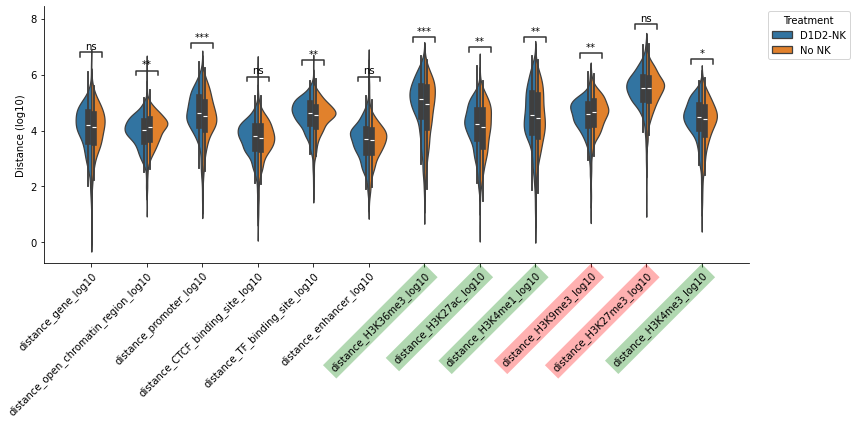

In [68]:
distance_fields = [f for f in perIS.columns if f.startswith('distance')]
Distance = perIS[perIS['Viremia']][['Treatment']+distance_fields].copy()
log10_col = []
for feature in distance_fields:
    log10_col.append('{}_log10'.format(feature))
    Distance.loc[:,'{}_log10'.format(feature)]=Distance[feature].apply(lambda x: np.log10(abs(x)) if x!=-1 else np.nan)

df_melted = Distance.melt(id_vars=['Treatment'], 
                    value_vars=log10_col,
                    var_name='Genetic Feature', 
                    value_name='Distance (log10)')


import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import numpy as np

# keep only the two groups you want to compare
df_filtered = df_melted[df_melted['Treatment'].isin(['D1D2-NK', 'No NK'])].copy()

# order categories (use your current order if you like)
features = list(df_filtered['Genetic Feature'].unique())
hue_order = ['D1D2-NK', 'No NK']

plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=df_filtered,
    x='Genetic Feature',
    y='Distance (log10)',
    hue='Treatment',
    split=True,
    order=features,
    hue_order=hue_order
)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
plt.xlabel('')

# Build comparison pairs: one pair per feature across the two hue levels
pairs = [((feat, 'D1D2-NK'), (feat, 'No NK')) for feat in features]

annot = Annotator(
    ax, pairs,
    data=df_filtered,
    x='Genetic Feature',
    y='Distance (log10)',
    hue='Treatment',
    order=features,
    hue_order=hue_order
)

annot.configure(
    test='Mann-Whitney',  # or 'greater' / 'less'
    comparisons_correction='BH',               # Benjamini–Hochberg FDR
    text_format='star',
    loc='inside',
    line_offset=0.02,
    line_height=0.02,
    verbose=0
)
annot.apply_and_annotate()

ax.legend(title="Treatment", loc="upper right", bbox_to_anchor=(1.15, 1))

labels = ax.get_xticklabels()

for label in labels:
    if 'H3K9me3'  in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3K27me3' in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3' in label.get_text():
        label.set_bbox(dict(facecolor='green', alpha=0.3, edgecolor='none'))

labels = ax.get_xticklabels()

for label in labels:
    if 'H3K9me3'  in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3K27me3' in label.get_text():
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))
        continue
    if 'H3' in label.get_text():
        label.set_bbox(dict(facecolor='green', alpha=0.3, edgecolor='none'))

plt.tight_layout()
plt.savefig('../figures/distance_comp_viremia.png',dpi=300)

In [69]:
# below is generated by claude code

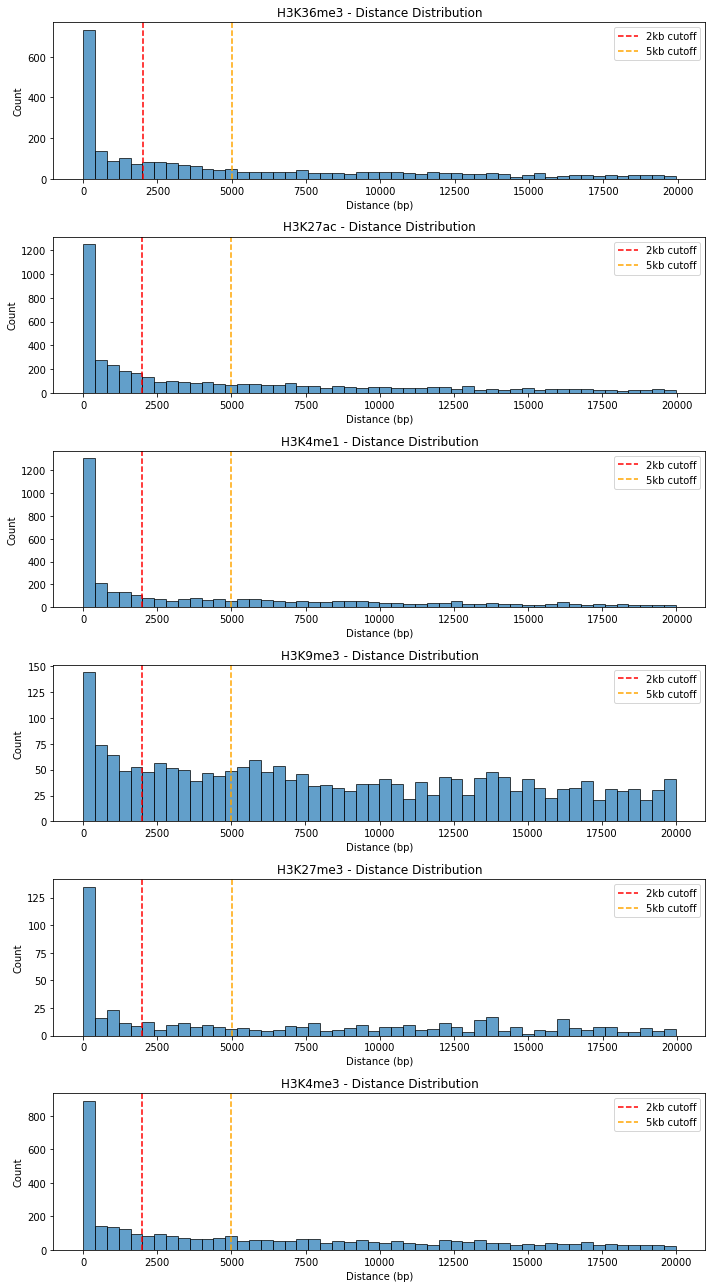

Distance summary statistics (excluding -1 values):

H3K36me3:
  Median: 56687 bp
  Mean: 254831 bp
  25th percentile: 6636 bp
  75th percentile: 272357 bp
  % within 2kb: 16.0%
  % within 5kb: 23.0%

H3K27ac:
  Median: 9454 bp
  Mean: 36328 bp
  25th percentile: 1198 bp
  75th percentile: 39829 bp
  % within 2kb: 30.0%
  % within 5kb: 40.1%

H3K4me1:
  Median: 15040 bp
  Mean: 162527 bp
  25th percentile: 1573 bp
  75th percentile: 112755 bp
  % within 2kb: 26.6%
  % within 5kb: 34.0%

H3K9me3:
  Median: 45590 bp
  Mean: 88239 bp
  25th percentile: 15475 bp
  75th percentile: 110180 bp
  % within 2kb: 5.4%
  % within 5kb: 10.5%

H3K27me3:
  Median: 298688 bp
  Mean: 714354 bp
  25th percentile: 105744 bp
  75th percentile: 734186 bp
  % within 2kb: 2.7%
  % within 5kb: 3.7%

H3K4me3:
  Median: 19222 bp
  Mean: 54163 bp
  25th percentile: 3901 bp
  75th percentile: 62288 bp
  % within 2kb: 19.6%
  % within 5kb: 27.7%


In [70]:
# For HIV integration sites, different cutoffs have different biological meanings:
# - 0 bp: Direct overlap with histone mark
# - 2000 bp: Within nucleosome-scale regulatory region
# - 5000 bp: Within local chromatin domain
# Common in HIV integration literature: 2000-5000 bp

# First, let's examine the distribution of distances to inform cutoff choice
histone_distance_cols = [col for col in perIS.columns if col.startswith('distance_') and 'H3' in col]

# Visualize distance distributions
fig, axes = plt.subplots(len(histone_distance_cols), 1, figsize=(10, 3*len(histone_distance_cols)))
if len(histone_distance_cols) == 1:
    axes = [axes]

for idx, col in enumerate(histone_distance_cols):
    mark_name = col.replace('distance_', '')
    
    # Filter out -1 values and take absolute distances
    valid_distances = perIS[perIS[col] != -1][col].abs()
    
    axes[idx].hist(valid_distances[valid_distances <= 20000], bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Distance (bp)')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{mark_name} - Distance Distribution')
    axes[idx].axvline(x=2000, color='red', linestyle='--', label='2kb cutoff')
    axes[idx].axvline(x=5000, color='orange', linestyle='--', label='5kb cutoff')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('../figures/histone_distance_distributions.png', dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
print("Distance summary statistics (excluding -1 values):")
for col in histone_distance_cols:
    mark_name = col.replace('distance_', '')
    valid_distances = perIS[perIS[col] != -1][col].abs()
    print(f"\n{mark_name}:")
    print(f"  Median: {valid_distances.median():.0f} bp")
    print(f"  Mean: {valid_distances.mean():.0f} bp")
    print(f"  25th percentile: {valid_distances.quantile(0.25):.0f} bp")
    print(f"  75th percentile: {valid_distances.quantile(0.75):.0f} bp")
    print(f"  % within 2kb: {(valid_distances <= 2000).mean()*100:.1f}%")
    print(f"  % within 5kb: {(valid_distances <= 5000).mean()*100:.1f}%")

In [71]:
# Use 2kb cutoff (common in HIV integration literature)
# This captures integration within/near histone-marked regions
cutoff = 2000

# Get histone mark distance columns
histone_distance_cols = [col for col in perIS.columns if col.startswith('distance_') and 'H3' in col]

# Create binary columns based on cutoff
for col in histone_distance_cols:
    mark_name = col.replace('distance_', '')
    # Integration is "in" the mark if distance exists (not -1) and is within cutoff
    perIS[f'In_{mark_name}'] = (perIS[col] != -1) & (perIS[col].abs() <= cutoff)

# Get list of histone marks
histone_marks = [col.replace('distance_', '') for col in histone_distance_cols]

# Separate active and repressive marks for biological interpretation
active_marks = [m for m in histone_marks if any(x in m for x in ['H3K4me3', 'H3K27ac', 'H3K36me3', 'H3K4me1'])]
repressive_marks = [m for m in histone_marks if any(x in m for x in ['H3K9me3', 'H3K27me3'])]

print(f"Active marks: {active_marks}")
print(f"Repressive marks: {repressive_marks}")

# Calculate odds ratios
odds_histone = []
pvals_histone = []

for mark in histone_marks:
    odd, p = generate_explain(perIS, mark, verbose=True)
    print(f"\n{mark}:")
    odds_histone.append(odd)
    pvals_histone.append(p)

odds_histone_df = pd.DataFrame(odds_histone).set_index('Element')
pvals_histone_df = pd.DataFrame(pvals_histone).set_index('Element')

odds_histone_df.to_csv('../csvfiles/odds_histone.csv')
pvals_histone_df.to_csv('../csvfiles/pvals_histone.csv')

Active marks: ['H3K36me3', 'H3K27ac', 'H3K4me1', 'H3K4me3']
Repressive marks: ['H3K9me3', 'H3K27me3']

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[332, 1185], [316, 1841]]  odds_ratio=1.63  p=1.16e-08

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[332, 1185], [488, 3113]]  odds_ratio=1.79  p=2.67e-13

D1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):
table=[[332, 1185], [804, 4954]]  odds_ratio=1.73  p=1.69e-13

H3K36me3:

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[492, 1025], [590, 1567]]  odds_ratio=1.27  p=0.000516

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[492, 1025], [1046, 2555]]  odds_ratio=1.17  p=0.00887

D1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):
table=[[492, 1025], [1636, 4122]]  odds_ratio=1.21  p=0.0013

H3K27ac:

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[398, 1119], [498, 1659]]  odds_ratio=1.18  p=0.016

D1D2-NK vs GFP-NK (one-si

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/1800615389.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


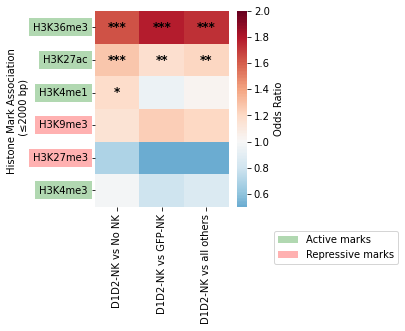


Summary: HIV Integration Site Association with Histone Marks (≤2000 bp)

Odds Ratios:
          D1D2-NK vs No NK  D1D2-NK vs GFP-NK  D1D2-NK vs all others
Element                                                             
H3K36me3             1.632              1.787                  1.726
H3K27ac              1.275              1.172                  1.209
H3K4me1              1.185              0.941                  1.023
H3K9me3              1.146              1.249                  1.209
H3K27me3             0.690              0.348                  0.429
H3K4me3              0.986              0.795                  0.859

P-values:
          D1D2-NK vs No NK  D1D2-NK vs GFP-NK  D1D2-NK vs all others
Element                                                             
H3K36me3            0.0000             0.0000                 0.0000
H3K27ac             0.0005             0.0089                 0.0013
H3K4me1             0.0160             0.8204                 0.3788
H3K9m

In [72]:
# Visualize with separate sections for active/repressive marks
plt.figure(figsize=(3, len(histone_marks) * 0.6))
ax = sns.heatmap(odds_histone_df.astype(float), 
                 vmin=0.5, vmax=2,  # Odds ratio scale
                 cmap='RdBu_r', 
                 center=1,
                 cbar_kws={'label': 'Odds Ratio'})

# Add significance markers
for i in range(len(histone_marks)):
    for j in range(3):
        p = pvals_histone_df.iloc[i, j]
        marker = ''
        if p < 0.001:
            marker = '***'
        elif p < 0.01:
            marker = '**'
        elif p < 0.05:
            marker = '*'
                
        if marker:
            ax.text(j + 0.5, i + 0.5, marker, 
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=12, weight='bold', color='black')

# Highlight active vs repressive marks with colored backgrounds
'''for i, mark in enumerate(histone_marks):
    if mark in active_marks:
        ax.add_patch(plt.Rectangle((-0.1, i), 0.1, 1, 
                                   facecolor='green', alpha=0.3, 
                                   transform=ax.transData, clip_on=False))
    elif mark in repressive_marks:
        ax.add_patch(plt.Rectangle((-0.1, i), 0.1, 1, 
                                   facecolor='red', alpha=0.3, 
                                   transform=ax.transData, clip_on=False))

'''

labels = ax.get_yticklabels()


for label in labels:
    mark = label.get_text()
    if mark in active_marks:
        label.set_bbox(dict(facecolor='green', alpha=0.3, edgecolor='none'))
    elif mark in repressive_marks:
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.3, label='Active marks'),
    Patch(facecolor='red', alpha=0.3, label='Repressive marks')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.3, -0.1))



ax.set_ylabel(f'Histone Mark Association \n (≤{cutoff} bp)')
plt.tight_layout()
plt.savefig(f'../figures/Histone_association_cutoff{cutoff}.png', dpi=300, bbox_inches="tight")
plt.show()

# Display summary table
print("\n" + "="*80)
print(f"Summary: HIV Integration Site Association with Histone Marks (≤{cutoff} bp)")
print("="*80)
print("\nOdds Ratios:")
print(odds_histone_df.round(3))
print("\nP-values:")
print(pvals_histone_df.round(4))


VIREMIA-SPECIFIC ANALYSIS

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[96, 690], [100, 442]]  odds_ratio=0.615  p=0.999

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[96, 690], [311, 2461]]  odds_ratio=1.1  p=0.238

D1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):
table=[[96, 690], [411, 2903]]  odds_ratio=0.983  p=0.577

H3K36me3 (Viremia only):

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[171, 615], [167, 375]]  odds_ratio=0.624  p=1

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[171, 615], [747, 2025]]  odds_ratio=0.754  p=0.999

D1D2-NK vs others (one-sided Fisher, H1: D1D2-NK > others):
table=[[171, 615], [914, 2400]]  odds_ratio=0.73  p=1

H3K27ac (Viremia only):

D1D2-NK vs No NK (one-sided Fisher, H1: D1D2-NK > No NK):
table=[[137, 649], [134, 408]]  odds_ratio=0.643  p=1

D1D2-NK vs GFP-NK (one-sided Fisher, H1: D1D2-NK > GFP-NK):
table=[[137, 649], [737, 2035]]  odds_ratio=0.58

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_2309/214178889.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


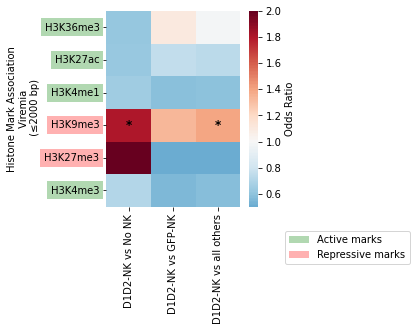

In [73]:
# Same analysis but for viremia samples only
print("\n" + "="*80)
print("VIREMIA-SPECIFIC ANALYSIS")
print("="*80)

odds_histone_viremia = []
pvals_histone_viremia = []

for mark in histone_marks:
    odd, p = generate_explain(perIS[perIS['Viremia']], mark, verbose=True)
    print(f"\n{mark} (Viremia only):")
    odds_histone_viremia.append(odd)
    pvals_histone_viremia.append(p)

odds_histone_viremia_df = pd.DataFrame(odds_histone_viremia).set_index('Element')
pvals_histone_viremia_df = pd.DataFrame(pvals_histone_viremia).set_index('Element')

odds_histone_viremia_df.to_csv('../csvfiles/odds_viremia_histone.csv')
pvals_histone_viremia_df.to_csv('../csvfiles/pvals_viremia_histone.csv')

# Visualize
plt.figure(figsize=(3, len(histone_marks) * 0.6))
ax = sns.heatmap(odds_histone_viremia_df.astype(float), 
                 vmin=0.5, vmax=2,
                 cmap='RdBu_r', 
                 center=1,
                 cbar_kws={'label': 'Odds Ratio'})

for i in range(len(histone_marks)):
    for j in range(3):
        p = pvals_histone_viremia_df.iloc[i, j]
        marker = ''
        if p < 0.001:
            marker = '***'
        elif p < 0.01:
            marker = '**'
        elif p < 0.05:
            marker = '*'
        if marker:
            ax.text(j + 0.5, i + 0.5, marker, 
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=12, weight='bold', color='black')


'''
# Highlight active vs repressive marks with colored backgrounds
for i, mark in enumerate(histone_marks):
    if mark in active_marks:
        ax.add_patch(plt.Rectangle((-0.1, i), 0.1, 1, 
                                   facecolor='green', alpha=0.3, 
                                   transform=ax.transData, clip_on=False))
    elif mark in repressive_marks:
        ax.add_patch(plt.Rectangle((-0.1, i), 0.1, 1, 
                                   facecolor='red', alpha=0.3, 
                                   transform=ax.transData, clip_on=False))

'''



labels = ax.get_yticklabels()


for label in labels:
    mark = label.get_text()
    if mark in active_marks:
        label.set_bbox(dict(facecolor='green', alpha=0.3, edgecolor='none'))
    elif mark in repressive_marks:
        label.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='none'))


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.3, label='Active marks'),
    Patch(facecolor='red', alpha=0.3, label='Repressive marks')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.3, -0.1))

ax.set_ylabel(f'Histone Mark Association\n Viremia \n (≤{cutoff} bp)')


plt.tight_layout()
plt.savefig(f'../figures/Histone_association_viremia_cutoff{cutoff}.png', dpi=300, bbox_inches="tight")
plt.show()